# Flow Network Solver

### General imports

In [1]:
# %pylab
# %run FastFlowNets.py 64 1 0
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys, os
args = sys.argv
sys.executable

import numpy as np
import copy
from numpy import zeros as zeros
from numpy import ones as ones
from numpy import array as array
from numpy import arange as arange
from numpy import meshgrid as meshgrid
from numpy import dot as dot
from numpy.linalg import inv as inv

# import cupy as cp

import cProfile
import re
import time

import numpy.linalg as la
import numpy.random as rand
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from datetime import datetime

# My functions
import NETfuncs, Constraints, Matrixfuncs, Statistics, Classes, Big_Class, FileFuncs, DatasetManipulations

In [2]:
## for plots and data save

# figure size
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams.update({'font.size': 14})

# comp_path = "C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\figs and data\\"
comp_path = "C:\\Users\\roiee\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\figs and data\\"

### Roie Larger Network

In [3]:
# User variables

NGrid = 44  # lattice dimension is Ngrid X Ngrid
# NGrid = 7  # for counter, lattice dimension is Ngrid X 1
# NGrid = 3 # lattice dimansion is Ngrid X Ngrid

# task_type = 'Allostery_one_pair'  # 1 pair of input and outputs
# task_type = 'Allostery'  # 2 pairs of input and outputs
task_type = 'Allostery_contrastive'  # 1 input, 2 outputs, 1 ground
# task_type = 'Regression_contrastive'  # 1 input, 2 outputs, 1 ground
# task_type = 'Flow_clockwise'  # 2 pairs of input and outputs, test is flowing from both inputs to both outputs
# task_type = 'XOR'  # 2 inputs and 2 outputs. difference between output nodes encodes the XOR result of the 2 inputs
# task_type = 'Channeling_diag'  # 1st from input to diagonal output, then from output to 2 perpindicular nodes. 
#                                # test from input to output
# task_type = 'Channeling_straight' # 1st from input to output on same column, then from output to 2 perpindicular nodes. 
#                                   # test from input to output (same as 1st)
# task_type = 'Counter'  # 1 col of cells, task: # marbles in right arm of crosses equals # of drive cycles.
# task_type = 'Memristor'  # 1 col of cells, task: # marbles in right arm of crosses equals # of drive cycles.
# task_type = 'Iris'  # classify 3 irises (outputs) given 4 inputs. Training randomly picks input node values 
#                     # from predetermined dataset and output node to block
# sub_task_type = '2in2out'
sub_task_type = '2in1out'

if task_type == 'Allostery_contrastive':
    # flow_scheme='taktak'
    flow_scheme='None'
else:
    flow_scheme='None'
    
# row = int(np.floor(np.sqrt(NGrid))-1)  # row (and column) of input and output nodes in the NGrid X NGrid cell array
row = 8

# Assign input and output nodes a.f.o lattice size and row choice
# input_output_pairs, fixed_nodes = Constraints.build_input_output_and_fixed(task_type, row, NGrid)
input_nodes_lst, output_nodes_lst, fixed_nodes = Constraints.build_input_output_and_fixed(task_type, sub_task_type, row, 
                                                                                          NGrid)

## These are defaults
# Periodic = False  # flag for lattice periodicity
# net_typ = 'Cells'  # layout for NETfuncs plotNetStructure(). 'Cells' is my style of network and is default
# u_thresh = 1  # threshold to move marbles

# # Schemes to change conductivities and order of pressure appliance in training and test
# if task_type == 'Allostery_one_pair':
#     K_scheme = 'propto_current_squared'
#     flow_scheme = 'one_shot'  # apply pressure drop from 1 output node and 1 output node, wait till convergence
#     net_typ = 'Cells'
# elif task_type == 'Channeling_straight' or task_type == 'Channeling_diag':
#     K_scheme = 'marbles_pressure'
#     flow_scheme = 'one_shot'  # apply pressure drop from 1 output node and 1 output node, wait till convergence
#     net_typ = 'Cells'
# elif task_type == 'Counter':
#     K_scheme = 'marbles_pressure'
#     flow_scheme = 'unidir'
#     net_typ = 'oneCol'
# elif task_type == 'Iris':
#     K_scheme = 'marbles_pressure'
#     flow_scheme = 'Contrastive'
#     net_typ = 'Cells'
# else:
#     K_scheme = 'marbles_pressure'
#     flow_scheme = 'unidir'  # apply pressure drop only in the regular directions - constrained node = positive, ground = 0
#                             # there are 2 input and output pairs, exchange between them
#     # flow_scheme = 'taktak'  # apply pressure drop unidir once, meaning 1st input and output pair and then 2nd pair.
#                               # then switch ground and constrained nodes to apply oposite dir.
#     net_typ = 'Cells'


# K_type = 'bidir'  # conductivity is the same regardless of flow directions
K_type = 'flow_dep'  # conductivity depends on flow direction - if into cell then maximal, 
                     # if out and there is a marble then lower

# Only for conductivity proportional to current squared scheme    
beta = 10**(-2)
# beta = 0
# print('beta is:' + str(beta))

K_max = 1
# K_min = np.array([0.0001])  # for counter
# K_min = np.array([0.5])  # real value
# K_min = np.array([0.3])  # for Allostery_contrastive
# K_min = np.array([0.1])  # for Regression_contrastive
K_min = np.array([0.001])
# K_min = np.array([1/(4*(NGrid-2*row)-1)])  # theoretical marginal for channeling
# K_min = np.logspace(-2.2, -0.0001, num=8, base=10)

# input_p = np.logspace(1.2, 2.2, num=50, base=10)
input_p = np.array([1])  # for counter
# p_small = 0.1  # for memristor
# p_large = 100  # for memristor
# input_p = np.concatenate((np.linspace(p_small, p_large, 10),  np.linspace(p_large, p_small, 10)))  # for memristor
# input_p = np.array([1])  # for Allostery_contrastive

# fixed_node_p = 5*(NGrid-1)/NGrid  # something in the middle
fixed_node_p = 0

noise = 0.0  # noise on initial marble configuration

iterations = 4  # # iterations allowed under flow cycles / updating conductivities

use_gpu = False
solver = Classes.Solver(use_gpu)

## Networkx sizes
scale = 5
squish = 0.01

## for Iris dataset calssification 
train_frac = 0.8

## for Contrastive learning
etta = 1
# desired_p_frac = array([[0.25, 0.1],[0.1, 0.2]])  # regression 2in2out
desired_p_frac = array([0.2, 0.3])  # regression 2in1out
# desired_p_frac = array([[0.5, 0.05],[0.5, 0.05]])  # Midway solution
# desired_p_frac = array([0.9, 0.1])  # Midway solution
# mag_factor = (NGrid-2*row) * 6  # for Allostery and Regression, no 'taktak'
mag_factor = (NGrid-2*row) * 5

u_thresh = 1  # p threshold for moving the marbles

In [4]:
## Prints

# print('input output node pairs are:\n' + str(input_output_pairs) +'\n')
print('input nodes are:\n' + str(input_nodes_lst) + '\nground nodes are:\n' + str(output_nodes_lst) +'\n' + 
     '\nfixed nodes are:\n' + str(fixed_nodes))

print('\npressure is:')
for i in input_p:
    print(i)
    
print('\nK min is:')
for i in K_min:
    print(i)

input nodes are:
[1804]
ground nodes are:
[7879]

fixed nodes are:
[1939 7744]

pressure is:
1

K min is:
0.001


In [5]:
## Variables class - mostly user choices

Variabs = Classes.User_variables(NGrid, input_p, task_type, K_type, iterations, input_nodes_lst, output_nodes_lst, 
                                 Periodic='False', u_thresh=u_thresh, fixed_nodes=fixed_nodes, K_max=K_max, K_min=K_min, 
                                 beta=beta, train_frac=train_frac, desired_p_frac=desired_p_frac, etta=etta, 
                                 mag_factor=mag_factor, sub_task_type=sub_task_type, flow_scheme=flow_scheme)

if task_type == 'Counter':
    Variabs.assign_fixed_node_p(fixed_node_p)  # assign 0 pressure at counter outputs

In [6]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class.Big_Class(Variabs)

# CPU or GPU usage
BigClass.assign_solver(solver)

In [7]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Classes.Net_structure()
Strctr.build_incidence(Variabs)
if Variabs.task_type == 'Memristor':
    Variabs.update_u_thresh(Strctr)
BigClass.add_Strctr(Strctr)  # add to big class
# Identify edges at connections of cells and at boundaries for ease of use
Strctr.Boundaries_and_connections(BigClass)

In [8]:
## Initiate internal flow network state class

State = Classes.Net_state(use_gpu)
BigClass.add_State(State)  # add to big class

In [9]:
## build network graphics class and plot structure

NET = Classes.Networkx_net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot='no')
# pos_lattice = NETfuncs.plotNetStructure(NET.NET, plot='yes', node_labels=False)  # position lattice, datatype of networkx
# position lat. dtype=networkx
# pos_lattice = NETfuncs.plotNetStructure(NET.NET, layout='oneCol', plot='no', node_labels=True)
# print(NET.pos_lattice)
BigClass.add_NET(NET)  # add to big class

NET is ready


In [10]:
def flow_iterate_for_profiler():
    State.flow_iterate(BigClass, sim_type='w marbles', plot='yes', savefig='no') 

In [11]:
# more parameters

# learning rate
alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha

# task - allostery or regression by now
# task_type = 'Regression'
task_type = 'Allostery'

# training length
if np.size(alpha_vec[0])>1:  # if alpha is annealed
    training=len(alpha_vec[0])
else:
    training=60

### Main part - loop over both cond and pressure

started main loop
p= 1
cycle # 0

i= 0 
m= 0
ground edges are  (array([[6300, 6301, 6302, 6303]], dtype=int64),)  flow through them is  [[0.06095175 0.06095175 0.05435145 0.05435145]]  resulting in total  [ 0.2306064 -0.2306064]  flow normalized by input pressure
p at output: [0.5 0.5]
desired_p  [0.2 0.3]
p_nudge  [0.2 0.3]
error  0.6785714285714157
ratio 1.083333333333306
condition supplied


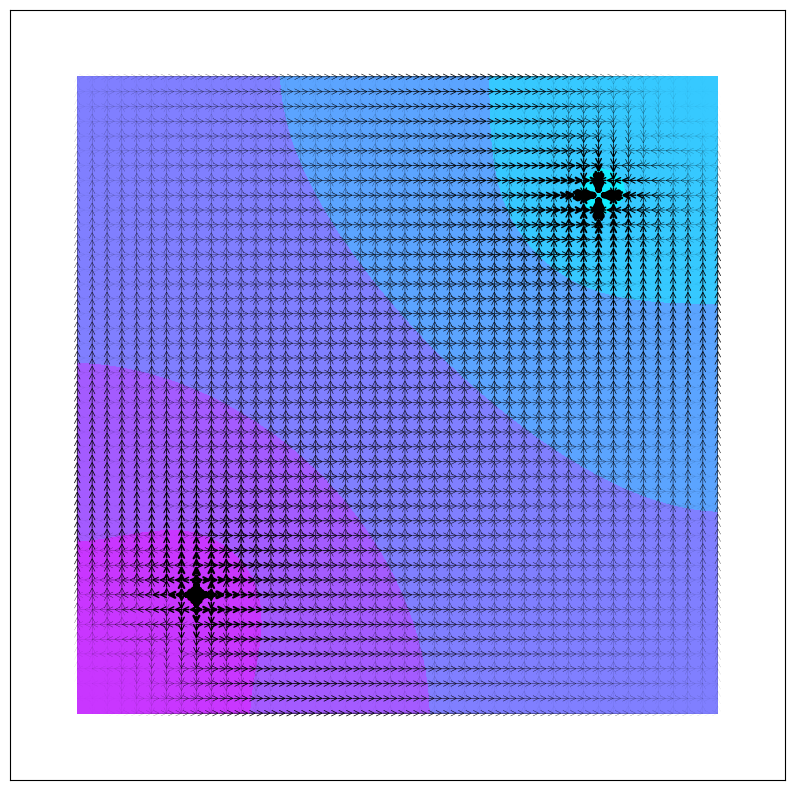

cycle # 0

i= 1 
m= 1
ground edges are  (array([[6300, 6301, 6302, 6303]], dtype=int64),)  flow through them is  [[0.03799694 0.03603755 0.03314676 0.04800868]]  resulting in total  [ 0.0011085 -0.0225862]  flow normalized by input pressure
condition supplied


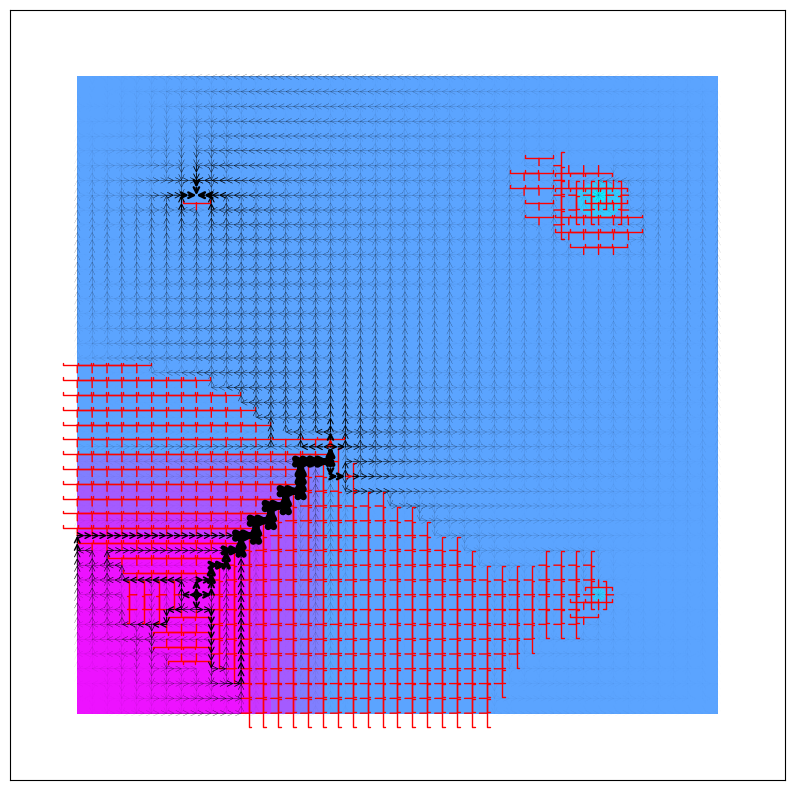

cycle # 1

i= 2 
m= 0
ground edges are  (array([[6300, 6301, 6302, 6303]], dtype=int64),)  flow through them is  [[0.00069184 0.00067195 0.00062185 0.00090435]]  resulting in total  [ 0.00288999 -0.00288999]  flow normalized by input pressure
p at output: [0.914703   0.91534779]
desired_p  [0.2 0.3]
p_nudge  [0.2 0.3]
error  1.1474741782382445
ratio 2.812337151426373
condition supplied


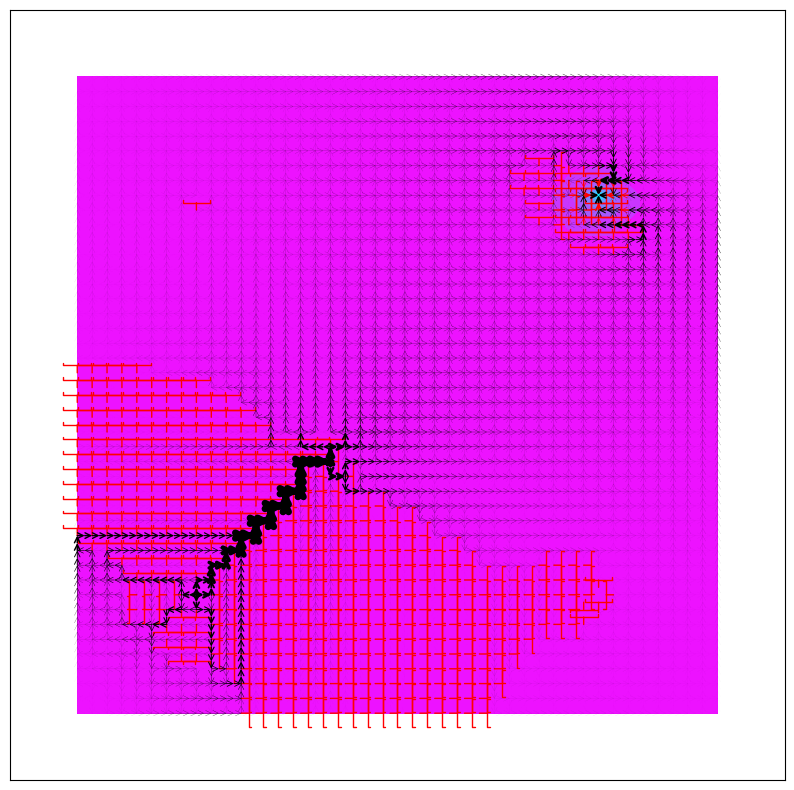

cycle # 1

i= 3 
m= 1
ground edges are  (array([[6300, 6301, 6302, 6303]], dtype=int64),)  flow through them is  [[0.03679298 0.03579032 0.03306699 0.04800596]]  resulting in total  [ 0.00109754 -0.02210228]  flow normalized by input pressure
condition supplied


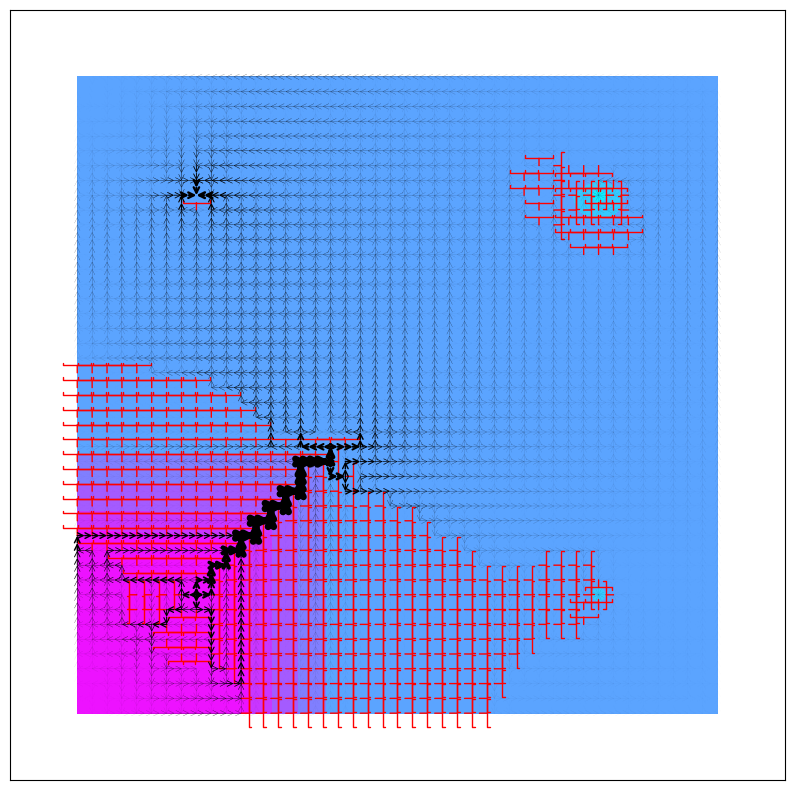

p= 1
total time for simulation 866.584826
100.0% done


In [12]:
# flow MSE and conductivity Hamming a.f.o input pressure

# Initiate MSE and Hamming matrices - MSE and Hamming for every iteration step (cols) a.f.o input p (rows)
power_dissip_arr = np.zeros([training])  # power dissipation at every training measurement step
p_allostery_arr = np.zeros([training])  # measured pressure at outputs
error_vec = np.zeros([training])  # error at each measure step in training

print('started main loop')
for i in range(training):

    start = time.time()  # time start of calculation for profiling

    # input pressure into Variabs Class
    Variabs.assign_input_p(p)

    # Set up constraints for whole loop
    Strctr.Setup_constraints(BigClass)

#         print(Strctr.GroundNodes_full)
#         print(Strctr.EdgesTotal)
#         print(Strctr.Edges_full)

    # Initiate K matrix again, not mandatory, better not doing it actually
    State.initiateK(BigClass, noise='no', noise_amp=noise)


    # Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
    #        change constraints and repeat
    flow_iterate_for_profiler()
    # State.flow_iterate(BigClass, sim_type='w marbles', plot='yes', savefig='no')
    # State.flow_iterate(Variabs, Strctr, NET, sim_type='w marbles', plot='yes', savefig='yes')

    # print(State.K)

    MSE_arr[:, i, j] = State.MSE
    Hamming_arr[:, i, j] = State.Hamming
    # print(State.power_dissip)
    power_dissip_arr[:, i, j] = State.power_dissip
    convergence_time_vec[i, j] = State.convergence_time

#         State.flow_iterate(BigClass, sim_type='allostery test', plot='yes', savefig='no')  # flow from both inputs
#                                                                                            # to both outputs

#         p_mat = Statistics.p_mat(State.p, BigClass.Variabs.NGrid)

    # FileFuncs.save_csv_files_Net(BigClass, p, K_min_i, comp_path)

    u_allostery_arr[:,:, i, j] = State.u_final
    print('p=', p)
    # print('u=', State.u_final)
#         shear_vec[i, j] = Statistics.shear_type(State.u_final)
#         print('shear is: ' + str(shear_vec[i]))

    end = time.time()  # time end of calculation for profiling
    dt = end-start  # total time it took to run calculation
    print('total time for simulation %f' %dt)
    
    print(str((i+1)*100/len(K_min)) + '% done')
        
convergence_time_vec[np.isnan(convergence_time_vec)] = Variabs.iterations

In [13]:
State.p_output
State.error_vec
int(np.floor(4/2))

2

In [14]:
Statistics.calc_loss(State.p_output, np.array([0.8, 0.7]), 'abs_diff')

1.9116575591985425

In [15]:
# plt.figure(figsize=(6, 6))
# plt.plot(input_p, linewidth=2, color='black')

# # Beautify the plot
# plt.xlabel('$t$', fontsize=24)
# plt.ylabel('$p$', fontsize=24)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.tight_layout()

error  [0.67857143 1.14747418] error improvement  -69.10145784563923 %


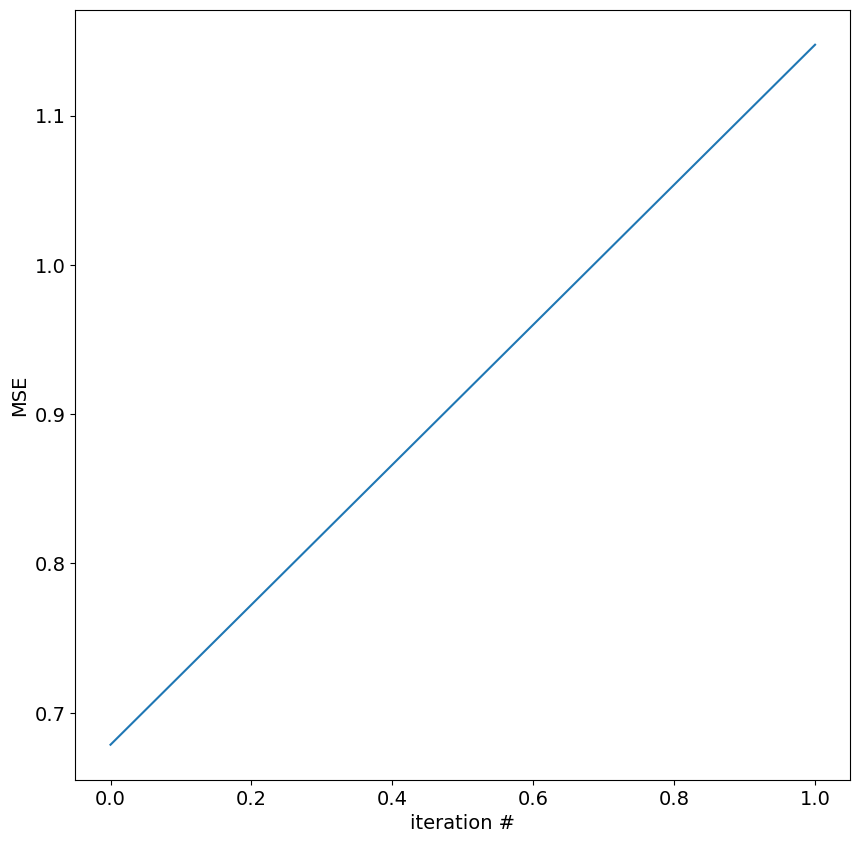

In [16]:
print('error ', State.error_vec, 'error improvement ', (State.error_vec[0]-State.error_vec[1])/State.error_vec[0]*100, '%')
plt.plot(State.error_vec)
plt.xlabel('iteration #')
plt.ylabel('MSE')
plt.show()

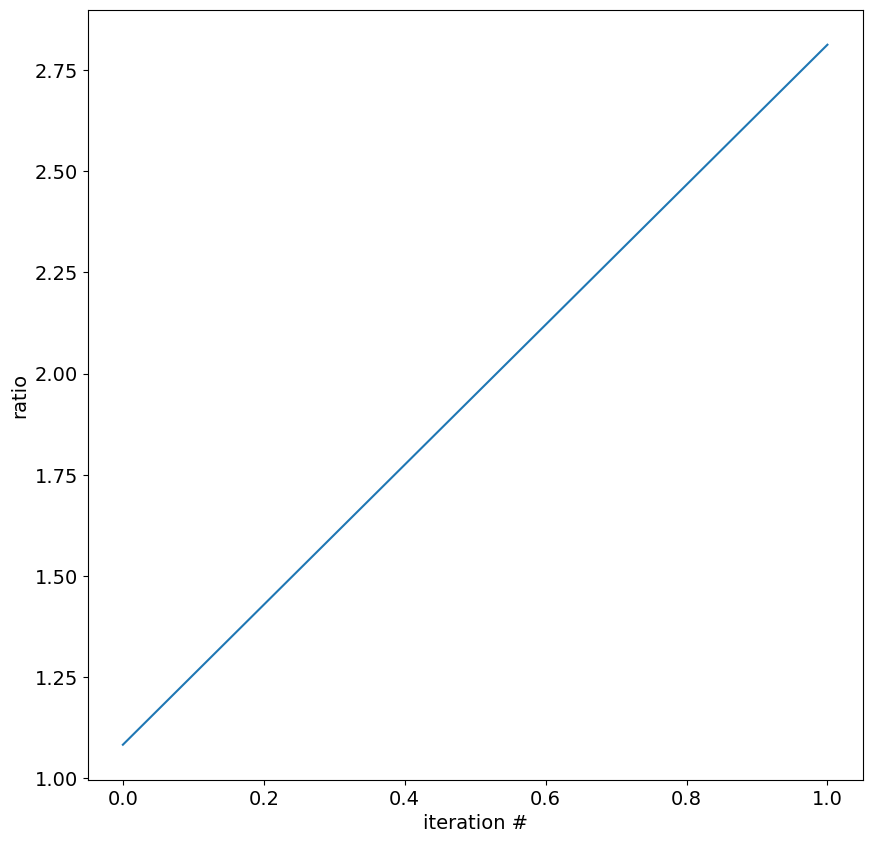

In [17]:
plt.plot(State.ratio_vec)
# plt.plot(desired_p_frac[0,1]/desired_p_frac[0,0]*np.ones(len(State.ratio_vec)))
# plt.ylim([-1,1.02])
plt.xlabel('iteration #')
plt.ylabel('ratio')
plt.show()

Text(0, 0.5, 'ratio')

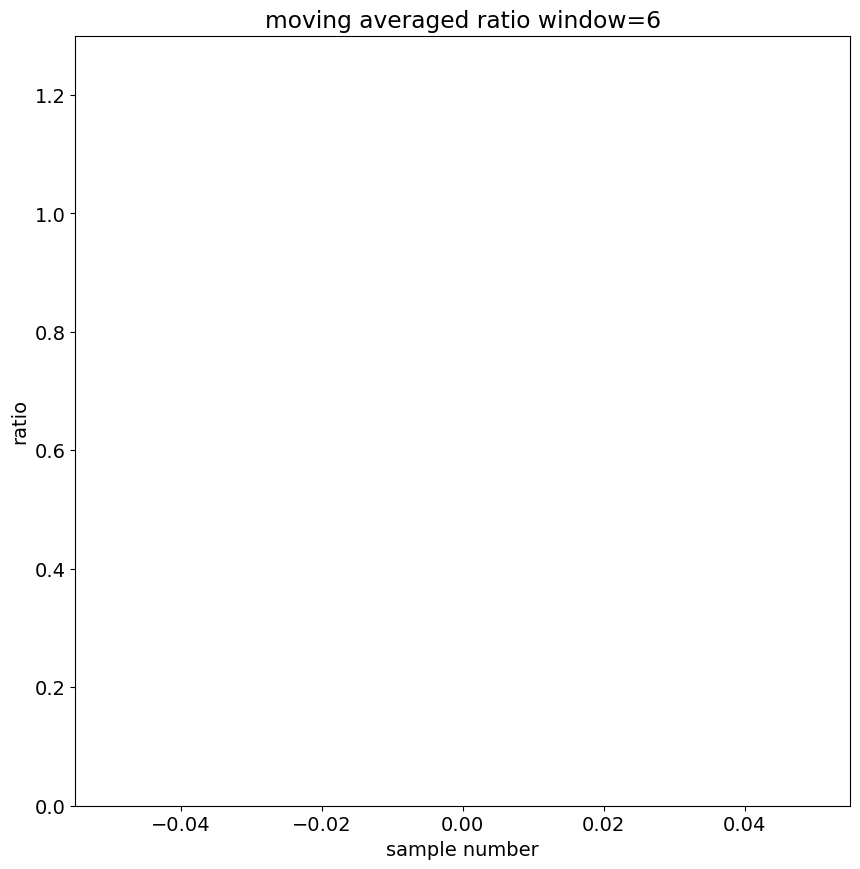

In [18]:
## Moving averaged ratio vec

# Program to calculate moving average
window_size = 6
 
i = 0
# Initialize an empty list to store moving averages
moving_averages = []
 
# Loop through the array to consider
# every window of size 3
while i < len(State.ratio_vec) - window_size + 1:
   
    # Store elements from i to i+window_size
    # in list to get the current window
    window = State.ratio_vec[i : i + window_size]
 
    # Calculate the average of current window
    window_average = round(sum(window) / window_size, 2)
     
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
     
    # Shift window to right by one position
    i += 1
    
plt.plot(moving_averages)
plt.title(f'moving averaged ratio window={window_size}')
plt.ylim([0,1.3])
plt.xlabel('sample number')
plt.ylabel('ratio')

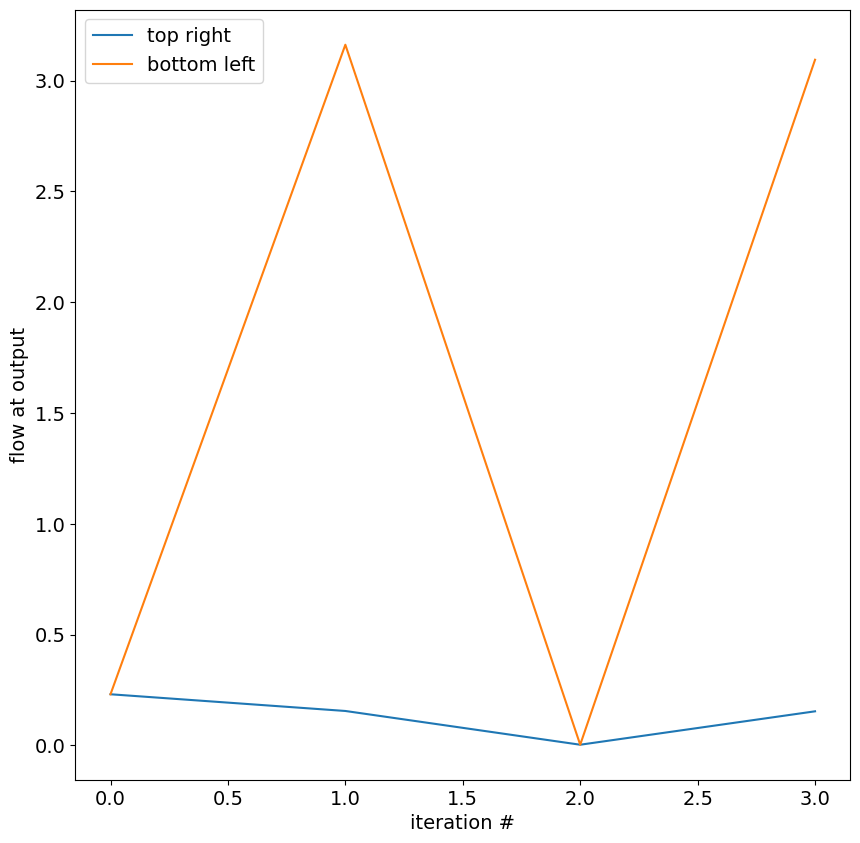

In [19]:
plt.plot(np.abs(State.u_final_vec))
# plt.plot(desired_p_frac[0,1]/desired_p_frac[0,0]*np.ones(len(State.ratio_vec)))
# plt.ylim([0,1.02])
plt.xlabel('iteration #')
plt.ylabel('flow at output')
plt.legend(['top right', 'bottom left'])
plt.show()

In [20]:
# # Save inportant data as CSV

# # import pandas as pd 

# datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
# print(datenow)

# # df1 = pd.DataFrame(u_allostery_arr)
# # print('C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network\\u_allostery' + str(datenow) + '.csv')
# # df1.to_csv("C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network\\u_allostery" + str(datenow) + ".csv")
# # df2 = pd.DataFrame(w_vec)
# # df2.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_w_vec.csv")
# df2 = pd.DataFrame(shear_vec, columns=[str(i) for i in input_p], index=[str(i) for i in K_min])
# df2.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_shear_vec.csv")

In [21]:
# df2 = pd.DataFrame(w_vec, columns=[str(i) for i in input_p], index=[str(i) for i in K_min])
# df2.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_w_vec.csv")

In [22]:
# ## Figures

# # prelims for figures
# datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
# print(datenow)

# # fig 1 - MSE, Hamming and Power dissip. afo p

# fig1, axes1 = plt.subplots(nrows=3)
# # axes.set_color_cycle(['332288', '88CCEE', '44AA99', '117733', '999933', 'DDCC77', 'CC6677', '882255', 'AA4499'])
# # cmap = plt.get_cmap('cool')
# cmap = sns.cubehelix_palette(as_cmap=True)
# colors = [cmap(i) for i in np.linspace(0, 1, len(MSE_arr[0,:]))]
# legend_every = 10

# for i, color in enumerate(colors, start=0):
#     if i % legend_every == 0:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color, label='K ratio='+str(K_min[i]))
#     else:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color)
#     axes1[1].plot(range(len(MSE_arr[:,0])), Hamming_arr[:,i], color=color)
#     axes1[2].plot(range(len(MSE_arr[:,0])), power_dissip_arr[:,i]/input_p[0], color=color)
# axes1[0].legend()
# # plt.show()
# axes1[2].set_xlabel('iteration #')
# axes1[0].set_ylabel('flow MSE')
# axes1[1].set_ylabel('Hamming dist.')
# axes1[2].set_ylabel('power')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'distance_and_P_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# # fig 2 - # cycles until convergence and tau p

# fig2, axes2 = plt.subplots(nrows=2, figsize=(10,6))
# axes2[0].semilogx(K_min, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# axes2[0].set_ylabel('# cycles')
# # axes2[1].plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# # axes2[1].set_xlabel('input $p$')
# # axes2[1].set_ylabel('$\\theta$')
# axes2[1].semilogx(K_min, shear_vec, '.', ms=20, mfc='white', label='$\\tau$')
# axes2[1].semilogx(K_min, np.zeros([len(K_min),]))
# axes2[1].set_xlabel('$\\frac{K_{min}}{K_{max}}$')
# axes2[1].set_ylabel('$\\tau$')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'numCycles_and_tau_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')